In [1]:
import sys

sys.path.append('.')

import model

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import seaborn as sns
import statistics

## Contextual vs. General Privacy Concerns

This experiment uses the BHES model to compare the effects of contextual vs. generalized privacy concerns on the effectiveness of a smartphone contract tracing system.

A key issue for any smartphone based contact tracing system is the proportion of contacts it successfully traces. Privacy concerns are one reason why contact tracing may fail. We consider two different kinds of privacy concerns:

 - *Contextual concerns*. These are concerns an individual has about a particular relationship or contact being disclosed to others with whom the are more familiar. Examples include:
   - A person is a member of a large and close-knit family. They have an affair or liason with somebody in a different family.
   - A person is an employee of a company where coworkers frequently meet. They take time off of work, saying that it is for a sick day. But really they are interviewing for another job.
   - A person visits a doctor or lawyer for a reason they would prefer to keep private.
 - *General concerns*. These are concerns an individual has about the infrastructual tracking of their location and/or contacts. Distrust of the smartphone service provider or surveilling government could be a reason for general concern.
 
 The purpose of this experiment is to show whether it matters to the effectiveness of the smartphone tracing system which form of privacy is dominant in a population, while holding the total level of privacy concern constant.

### Trading off general and contextual privacy

We operationalize generalized privacy concern as _non-adoption_ of the tracing system. A non-adopter will never have their contacts traced. It is assumed that "they did not install the app".

We operationalize contextual privacy concern as removal of _specific_ edges from the tracing network. This is controlled through the tracing probability of each edge $c$.

Aligned with the idea of tying tracing probability to _local density_, we will focus on the 'rewired' edges that are not in the outer circle lattice as being the most sensitive.

Given Watts-Strogatz parameters $N$, and $K$, and $p$, the number of rewired edges will be $\frac{NKp}{2}$.

We will define $\chi \in [0,1]$ as the proportion of these edges to have zero contact tracing $c = 0$. For a given level of $\chi$, there will be $\chi \frac{NK p}{2}$ such edges.

In [3]:
chi = 1

def chi_privacy(g, e, chi):
    u, v, d = e
    
    # a rewired edges
    if abs(u - v) % N > K / 2:
        if random.random() <= chi:
            return 0
        
    return 1

#### Watts-Strogatz Rewiring

The Watts-Strogatz model is designed to be a simple model that has triadic closure and local clustering on par with actually observed social networks.

It starts with a ring lattice of $N$ nodes with each node connected to $K$ neighbors. Then it rewires each edge with probability $\beta$. As $\beta$ approaches $1$, the network gets close to an Erods-Renyi graph $G(N,p)$ with $p = \frac{K}{N - 1}$.

Varying this $\beta$ parameter is motivate by the following narratives:
 * As the population is under "lockdown", people choose the most important contacts in their life and restrict their interactions to them. While the whole population is connected (via the ring lattice structure), they do not integrate much with other people outside their local community.
 * Easing the "lockdown", people are more able to interact with other parts of the network and take advantage of the social exchange opportunities available from looking outside one's network.

For general privacy, we will vary the adoption rate $A$. Since an adopter in effect deactivates tracing on all their edges, the number of active edges based on adoption is approximately $A^2 N K /2$.

In order to get comparability between contextual and general privacy concerns, and measure what happens if we trade them off, we will set $\hat{A} = (1 - \chi) \frac{N K \beta}{2}$. 

$$A^2 N K /2 = NK ( 1 - p) / 2 $$
$$A = \sqrt{1 - p}$$

$$(1 - \hat{A}^2) NK / 2 + \chi NK p / 2= NK p / 2 $$
$$\sqrt{1 - (p  - \chi p)} = \hat{A}$$

We will also have a base level of adoption ...

In [4]:
## Population parameters:
params = {
    # Node parameter
    'A' : None, # probability of adoption
    
    # Edge parameter
    'W' : model.expected_one_per_edge, # probability of edge activation
    'C' : None,
    
    ## Disease parameters

    'beta_hat' : 1, # probability of transmission upon contact
    'alpha' : .25, # probability of exposed becoming infectious
    'gamma' : .1, # probability of infectious becoming recovered
    'zeta' : .1, # probability of infectious becoming symptomatic

    ## Contact tracing parameters

    'limit' : 10, # number of time steps the contact tracing system remembers
}

In [11]:
import math

math.sqrt(100)

10.0

In [47]:
N = 1500
K = 10
ws_beta = .3
 
A_base = 1

def watts_strogatz_chi_case(chi):
    g = nx.watts_strogatz_graph(N, K, ws_beta)
    p = params.copy()
    
    p['A'] = math.sqrt(1 - (1 - chi) * ws_beta) # probability of adoption
    p['C'] = lambda g, e: chi_privacy(g, e, chi)
    
    return g, p

In [48]:
params

{'A': None,
 'W': <function model.expected_one_per_edge(g, e)>,
 'C': None,
 'beta_hat': 1,
 'alpha': 0.25,
 'gamma': 0.1,
 'zeta': 0.1,
 'limit': 10}

In [49]:
conditions = {
    'chi-0.00' : {'chi' : 0.00},
    'chi-0.50' : {'chi' : 0.50},
    'chi-1.00' : {'chi' : 1.00},
}

In [50]:
runs = 10

results = model.experiment(
    watts_strogatz_chi_case,
    conditions,
    runs)

chi-0.00
Trial 0
Trial 0 hits time step 100
Trial 1 hits time step 100
Trial 3 hits time step 100
Trial 4 hits time step 100
Trial 9 hits time step 100
chi-0.50
Trial 0
Trial 1 hits time step 100
Trial 2 hits time step 100
Trial 4 hits time step 100
Trial 7 hits time step 100
chi-1.00
Trial 0
Trial 2 hits time step 100
Trial 3 hits time step 100
Trial 4 hits time step 100
Trial 5 hits time step 100
Trial 5 hits time step 200
Trial 6 hits time step 100
Trial 7 hits time step 100
Trial 9 hits time step 100


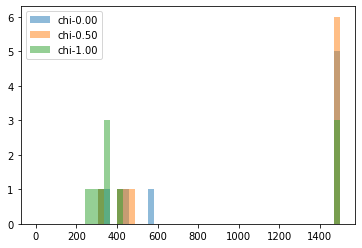

In [51]:
g = results['chi-0.00'][0][1]
bins = np.linspace(0, len(g.nodes()), 50)

for case in results:
    plt.hist(
        [len(model.susceptible(r[1]))
         for r
         in results[case]],
        bins,
        alpha=.5,
        label=case)
    
plt.legend()

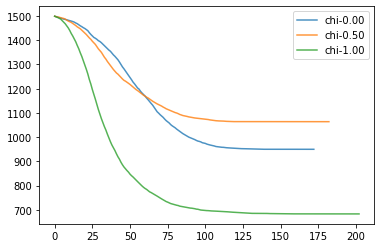

In [52]:
g = results['chi-0.00'][0][1]
bins = np.linspace(0, len(g.nodes()), 50)

for case in results:
    plt.plot(
        model.average_susceptible_over_time(results[case]),
        alpha=.8,
        label=case)
    
plt.legend()

In [64]:
g_test = results['chi-0.50'][5][1]

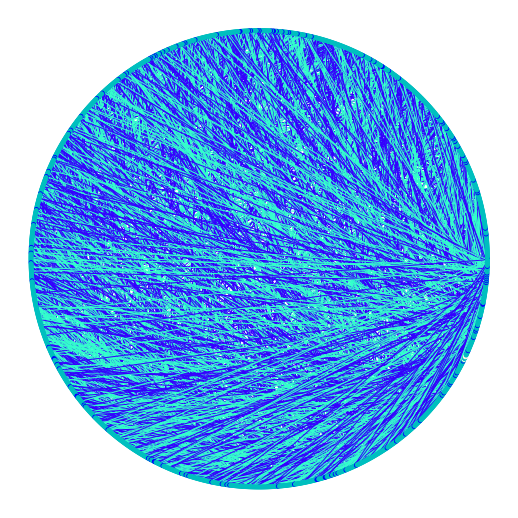

In [65]:
plt.figure(3,figsize=(7,7)) 
nx.draw_circular(g_test,
                node_size = 15,
                node_color = model.node_colors(g_test),
                edge_color = model.edge_colors(g_test))

In [66]:
len([n for n in g_test.nodes(data=True) if n[1]['adopter']])

1367